# Load data


In [3]:
# install cartopy, shapely, and geopandas as it is not in Colab by default...
!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.0 MB/s eta 0:00:00
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-linux_x86_64.whl size=969673 sha256=03494ec5ce59ebbfb92da85a3b702c8d8443e100890b450104db3735e44bd79b
  Stored in directory: /root/.cache/pip/wheels/07/bd/06/4e979fa263bca266484ee65f5aab8e6b1c9b20f8caa6f2d7da
Successfully built shapely
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 75.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 98.4 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102736 sha256=7d1737bbe4fd905a3e137f3d075ba949ac1ad34cb2863118a5953f17763109c1
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

### Loading data from Google Drive

Now we'll load the earthquake data. We first need to mount your Google Drive so that you can access the data from the shared drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To be more organized, let's manage our input and output directories using the `pathlib` module.

In [10]:
#This allows us to specify kung saan mase-save ang notebook and ang data directory
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve() # where this notebook is located
DATA_DIRECTORY = pathlib.Path("drive/Shareddrives/Geol197-GDAM/data/") # Geol 197 shared drive

# Output location
#First line specifies the path
#Second line creates the new folder
OUTPUT_DIR = pathlib.Path("drive/MyDrive/Geol197")
OUTPUT_DIR.mkdir(parents = True, exist_ok = True)

With your Google Drive mounted, you can now direct Colab to the csv file that we will open with `pandas`.

In [11]:
import pandas as pd
import geopandas as gpd

# Read selected columns of  data 
fp = r"drive/Shareddrives/Geol197-GDAM/data/eq_data/pivs202101.csv"
data = pd.read_csv(
    fp,
    usecols=["Date - Time\r\n(Philippine Time)", "Latitude\r\n(ºN)", "Longitude\r\n(ºE)", "Depth\r\n(km)", "Mag"],
)

# replace the \r\n in the column names with '' to delete them
data.columns = data.columns.str.replace('\r\n', '')

# Rename the columns
new_names = {
    "Date - Time(Philippine Time)": "TIME", 
    "Latitude(ºN)": "LAT", 
    "Longitude(ºE)": "LON", 
    "Depth(km)": "DEP"
}

data = data.rename(columns=new_names)

# create geopandas object from pandas df
#First line creates points from lon and lat data ng table
pivs_eq = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.LON, data.LAT))
pivs_eq.head()

,TIME,LAT,LON,DEP,Mag,geometry
0,31 January 2021 - 10:50 PM,14.75,121.91,24,1.9,POINT (121.91000 14.75000)
1,31 January 2021 - 08:44 PM,5.19,127.37,114,3.0,POINT (127.37000 5.19000)
2,31 January 2021 - 07:41 PM,9.01,126.95,1,2.4,POINT (126.95000 9.01000)
3,31 January 2021 - 01:14 PM,13.47,120.32,2,2.0,POINT (120.32000 13.47000)
4,31 January 2021 - 01:05 PM,9.00,126.91,1,2.5,POINT (126.91000 9.00000)


## Plot a map of the data

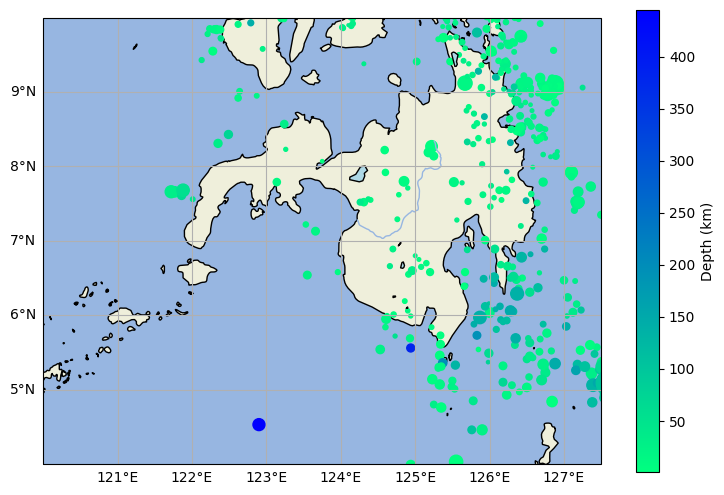

In [13]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

lakes = cfeature.GSHHSFeature(levels=[2,3,4])

extent = [120, 127.5, 4, 10]

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# here we use the magnitude size to change the diameter of the circles
#ax=ax is bc (sumn modularized etc search mo na lang T^T)
pivs_eq.plot(column='DEP',
         ax=ax,
         markersize=pivs_eq['Mag']**3,
         cmap='winter_r',
         legend=True,
         legend_kwds={'label': 'Depth (km)'}
         )

ax.set_extent(extent)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes, facecolor='lightblue', edgecolor='k')

# Customize the gridlines to disable labels for the top and right side of the map
# based on: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html#sphx-glr-gallery-gridlines-and-labels-gridliner-py
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels=False
gl.right_labels=False

### Functions for organization
Since I feel comfortable with my basemap and will plot it over and over again, I will save the basic parameters of the map into a function. ([*Plot*](https://colab.research.google.com/drive/1qCefsldlqL3zK0j6R8kU3HPgtsIpr49A#scrollTo=Plotting_cell))

In [15]:
#If you will be using a set of codes repeatedly, you can save them into a new function.
#Yung sa baba ay yung code sa taas na forda boomerang ginamit
def plot_basemap(grid=False):
  ax.set_extent(extent)
  ax.add_feature(cartopy.feature.OCEAN)
  ax.add_feature(cartopy.feature.LAND, edgecolor='black')
  ax.add_feature(cartopy.feature.RIVERS)
  ax.add_feature(lakes, facecolor='lightblue', edgecolor='k')

  # Customize the gridlines to disable labels for the top and right side of the map
  # based on: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html#sphx-glr-gallery-gridlines-and-labels-gridliner-py
  if grid == True:
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels=False
    gl.right_labels=False
  return

# Spatial analysis (joins)

## Selecting points inside polygons
Say we want to select points (earthquakes) that are inside a certain area. Let's first define some areas of interest using `shapely` and turn them into `geopandas` objects for easy spatial analysis and plotting on maps. ([*Plot*](https://colab.research.google.com/drive/1qCefsldlqL3zK0j6R8kU3HPgtsIpr49A#scrollTo=Plotting_cell))

In [22]:
from shapely.geometry import Polygon

#create polygon from coordinates (define boundaries)
#7-8 N, 124-125E; specify tuples of the coordinate, which are pairs of nos. inside parentheses.
#Start w the x value sa left and y sa right sa tuples
#Dots ay nilagay for Python to id them as floats
#Nasa loob ng square brackets to save it as a list of tuples
aoi1 = gpd.GeoSeries(Polygon([(124.,8.),(125.,8.),(125.,7.),(124.,7.)]))
aoi1
aoi2 = gpd.GeoSeries(Polygon([(125.5, 9.8), (125.5, 9.), (126., 9.)]))
aoi2

0    POLYGON ((125.50000 9.80000, 125.50000 9.00000...
dtype: geometry

The [geopandas.Geoseries.within()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html) function will allow us to select earthquakes within the polygon.

In [23]:
pivs_eq.within(aoi1[0]) #index kasi ay 0 nung mga coordinates ni aoi1

0      False
1      False
2      False
3      False
4      False
       ...  
778    False
779    False
780    False
781    False
782    False
Length: 783, dtype: bool

In [24]:
eqs_in_rect = pivs_eq[pivs_eq.within(aoi1[0])]

In [25]:
eqs_in_rect

,TIME,LAT,LON,DEP,Mag,geometry
60,28 January 2021 - 08:54 PM,7.55,124.40,10,2.2,POINT (124.40000 7.55000)
97,26 January 2021 - 11:57 PM,7.80,124.83,4,2.3,POINT (124.83000 7.80000)
110,26 January 2021 - 04:16 PM,7.80,124.85,11,3.6,POINT (124.85000 7.80000)
133,25 January 2021 - 10:05 PM,7.71,124.90,15,2.0,POINT (124.90000 7.71000)
523,12 January 2021 - 09:17 AM,7.92,124.60,2,2.7,POINT (124.60000 7.92000)
551,11 January 2021 - 06:10 AM,7.29,124.76,13,2.2,POINT (124.76000 7.29000)
571,10 January 2021 - 06:07 PM,7.62,124.78,7,2.1,POINT (124.78000 7.62000)
577,10 January 2021 - 06:57 AM,7.52,124.31,14,3.0,POINT (124.31000 7.52000)
585,09 January 2021 - 09:43 PM,7.56,124.37,24,2.2,POINT (124.37000 7.56000)
777,01 January 2021 - 02:54 AM,7.52,124.26,40,2.6,POINT (124.26000 7.52000)


To select data within polygons from a shapefile (or any geospatial dataset), we can do something like below. (Data obtained from https://data.humdata.org/dataset/cod-ab-phl)

In [34]:
munis = gpd.read_file(
    DATA_DIRECTORY / "gis" / "admin_bounds" / "phl_admbnda_adm3_psa_namria_20200529.shp"
)

In [36]:
munis.head()

,Shape_Leng,Shape_Area,ADM3_EN,ADM3_PCODE,ADM3_REF,ADM3ALT1EN,ADM3ALT2EN,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,1.601219,0.063496,Aborlan,PH175301000,NaN,NaN,NaN,Palawan,PH175300000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,NaN,"MULTIPOLYGON (((118.58350 9.37700, 118.58398 9..."
1,1.078749,0.050232,Abra de Ilog,PH175101000,NaN,NaN,NaN,Occidental Mindoro,PH175100000,Region IV-B,PH170000000,Philippines (the),PH,2016-06-30,2020-05-29,NaN,"POLYGON ((120.58412 13.50198, 120.58420 13.501..."
2,0.424301,0.006453,Abucay,PH030801000,NaN,NaN,NaN,Bataan,PH030800000,Region III,PH030000000,Philippines (the),PH,2016-06-30,2020-05-29,NaN,"POLYGON ((120.49873 14.75614, 120.49891 14.755..."
3,0.566053,0.011343,Abulug,PH021501000,NaN,NaN,NaN,Cagayan,PH021500000,Region II,PH020000000,Philippines (the),PH,2016-06-30,2020-05-29,NaN,"POLYGON ((121.43455 18.46651, 121.43502 18.466..."
4,1.013649,0.026124,Abuyog,PH083701000,NaN,NaN,NaN,Leyte,PH083700000,Region VIII,PH080000000,Philippines (the),PH,2016-06-30,2020-05-29,NaN,"MULTIPOLYGON (((125.02684 10.73500, 125.02683 ..."


<Axes: >

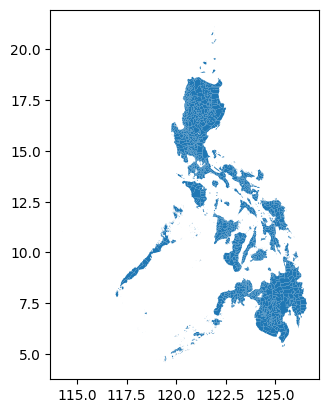

In [37]:
munis.plot()

## Aggregating data with `dissolve`
We can combine geometries by an attribute (column). In our case, we don't need municipal level data, so let's use [`dissolve`](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) to create geometries at the provincial level.  From the table above, we can see the province names are under the **ADM2_EN** attribute.

In [42]:
# dissolve by provinces and sum numerical attributes (aggfunc='sum'), like Shape_Area
#"by" ay parang groupby,, aggfunc ay kung ano gusto mong gawin (i.e. sum, difference, etc sa data)
provinces = munis.dissolve(by = "ADM2_EN", aggfunc = 'sum')

<ipython-input-42-610603b3f679>:3: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  provinces = munis.dissolve(by = "ADM2_EN", aggfunc = 'sum')


<Axes: >

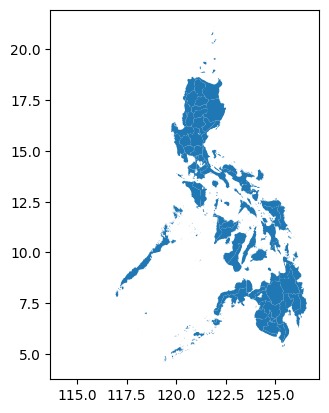

In [43]:
provinces.plot()

Let's check the result.

In [47]:
eqs_in_buk = pivs_eq[pivs_eq.within(provinces.at["Bukidnon", "geometry"])]
eqs_in_buk

,TIME,LAT,LON,DEP,Mag,geometry
97,26 January 2021 - 11:57 PM,7.80,124.83,4,2.3,POINT (124.83000 7.80000)
110,26 January 2021 - 04:16 PM,7.80,124.85,11,3.6,POINT (124.85000 7.80000)
133,25 January 2021 - 10:05 PM,7.71,124.90,15,2.0,POINT (124.90000 7.71000)
165,25 January 2021 - 01:19 AM,8.14,125.25,10,3.1,POINT (125.25000 8.14000)
166,25 January 2021 - 01:17 AM,8.19,125.18,11,3.4,POINT (125.18000 8.19000)
185,24 January 2021 - 06:45 PM,8.26,125.21,1,3.1,POINT (125.21000 8.26000)
189,24 January 2021 - 03:44 PM,8.27,125.22,6,4.1,POINT (125.22000 8.27000)
198,24 January 2021 - 07:58 AM,8.19,125.20,8,3.0,POINT (125.20000 8.19000)
523,12 January 2021 - 09:17 AM,7.92,124.60,2,2.7,POINT (124.60000 7.92000)
635,07 January 2021 - 09:02 PM,8.22,124.59,5,3.0,POINT (124.59000 8.22000)


Finally, we can now select epicenters for specific provinces, like Bukidnon.

## Writing geospatial data to a file

In [51]:
provinces.drop(columns = ["ADM3ALT1EN", "ADM3ALT2EN", "validTo"], inplace = True)

In [53]:
provinces.to_file(OUTPUT_DIR/"provinces.gpkg")

# Plotting cell

<GeoAxes: >

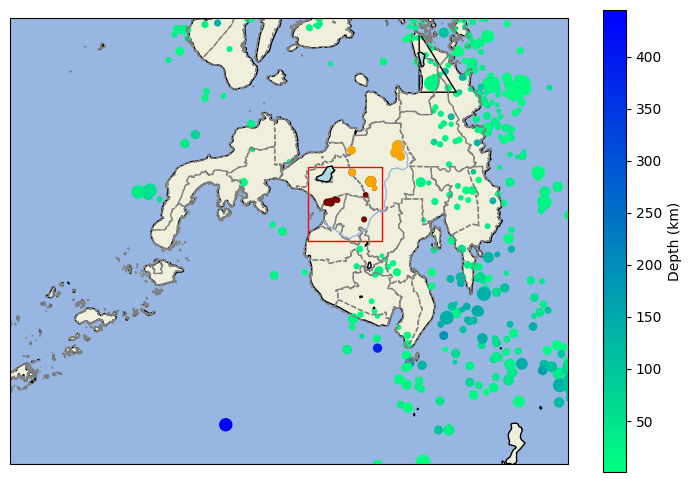

In [50]:
## Plotting Cell ##

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# here we use the magnitude size to change the diameter of the circles
pivs_eq.plot(column='DEP',
         ax=ax,
         markersize=pivs_eq['Mag']**3,
         cmap='winter_r',
         legend=True,
         legend_kwds={'label': 'Depth (km)'}
         )

plot_basemap()
#facecolor ay for fill, edgecolor ay for borders
aoi1.plot(ax=ax, facecolor = "none", edgecolor = "r")
aoi2.plot(ax=ax, facecolor = "none", edgecolor = "k")

provinces.plot(ax=ax, facecolor = "none", edgecolor = "gray", linestyle = "--")
eqs_in_rect.plot(ax=ax, facecolor = "maroon", markersize = eqs_in_rect['Mag']**3)
eqs_in_buk.plot(ax=ax, facecolor = "orange", markersize = eqs_in_buk['Mag']**3)

# More spatial analysis
We will not be able to discuss all possible spatial analysis operations. There are many other geometric manipulations available in GIS software, like getting features close to a line using [buffer](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html), and [getting overlaps or difference between shapes](https://geopandas.org/en/stable/docs/user_guide/set_operations.html). After all, most of these functionalities in GIS software actually run on Python! :)

 Explore the [GeoPandas user guide](https://geopandas.org/en/stable/docs/user_guide.html/) to find out more.